# 4. Поиск координат углов прямоугольника на изображении при помощи преобразования Хафа
Реализовать поиск координат углов прямоугольника при помощи классического преобразования Хафа на изображении, полученным при помощи класса из п.1. Привести листинг программы и 5 примеров работы (изображение, результаты вычислений, оценка точности). Будет большим плюсом реализация визуализации аккумулятора Хафа + визуализация найденных прямых на исходном изображении.


## Импорт библиотек

In [154]:
from skimage.transform import (hough_line, hough_line_peaks)
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.spatial import distance

## Генерация данных
Прямоугольники случайного цвета со сторонами от 150 до 250 пикселей, повернутые на случайный угол от 0 до 90 градусов.  

Фон - изображение 640 на 480 пикселей случайного цвета.

In [155]:
class object1:
    def ran1(self):
        self.img = np.zeros((480, 640, 3), np.uint8)
        self.img[:] = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255))
        width = random.randrange(100, 250)
        height = random.randrange(100, 250)
        diam = np.sqrt(width ** 2 + height ** 2)

        x1 = random.randrange(int(diam / 2 - width / 2), int(self.img.shape[1] - (diam / 2 - width / 2) - width))
        x2 = x1 + width
        y1 = random.randrange(int((diam / 2 - height / 2)), int(self.img.shape[0] - (diam / 2 - height / 2) - height))
        y2 = y1 + height

        points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])

        ANGLE = np.deg2rad(random.randrange(0, 89))
        c_x, c_y = np.mean(points, axis=0)
        points = np.array([[c_x + np.cos(ANGLE) * (px - c_x) - np.sin(ANGLE) * (py - c_y),
                            c_y + np.sin(ANGLE) * (px - c_x) + np.cos(ANGLE) * (py - c_y)]
                           for px, py in points]).astype(int)

        self.points = points
        self.describe = np.array([points[3][0], points[0][1], points[1][0] - points[3][0], points[2][1] - points[0][1]])
        self.img = cv2.drawContours(self.img, [points], 0,
                               (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)), -1)


In [156]:
image = object1()
image.ran1()

Отоблажение прямоугольника в черно-белом цвете

(480, 640)


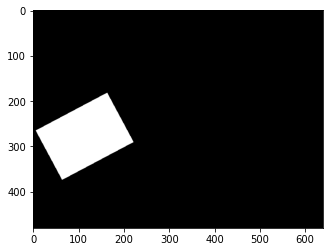

In [157]:
img = image.img
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img, cmap='gray')

# Визуализация аккумулятора Хафа
Аккумулятор представляет собой двумерный массив, два измерения которого соответствуют квантованным значениям параметров m и b (параметры прямых).   

Для каждой точки и её соседей алгоритм определяет, достаточен ли вес границы в этой точке. Если да, то алгоритм вычисляет параметры прямой и увеличивает значение в ячейке аккумулятора, соответствующей данным параметрам.

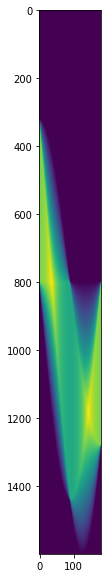

In [158]:
accumulator, thetas, rhos = hough_line(img)

plt.figure(figsize=(10,10))
plt.imshow(accumulator)  

`Получение параметров преобразования Хафа:`  
rho - расстояние от начала координат до линии.  
theta - угол от начала координат до линии. [-90° to 90°]  
С помощью данных параметров мы можем реализовать поиск сторон прямоугольника на изображении.

In [159]:
idx = np.argmax(accumulator)
rho = rhos[int(idx / accumulator.shape[1])]
theta = thetas[idx % accumulator.shape[1]]
print("rho={0:.2f}, theta={1:.0f}".format(rho, np.rad2deg(theta)))

rho=-1.50, theta=-54


## Получение вероятностных линий Хафа на изображении
Чтобы получить линии Хафа на изображении воспользуемся функцией `cv2.HoughLinesP` из библиотеки OpenCV, которая возвращает вероятностные линии Хафа на изображении.  
Параметрами функции являются:  
* dst: выходное изображения после определения границ в черном-белом цвете. 
* lines: вектор, получающий параметры обнаруженных линий
* rho : разрешение параметра в пикселях
* theta: разрешение параметра в радианах (используется в градусы)
* threshold: минимальное количество пересечений для определения линии
* minLineLength: минимальное количество точек для формирования линии
* maxLineGap: Максимальное расстояние между точками внутри одной линии

In [160]:
edges = cv2.Canny(img,50,150,apertureSize = 3)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)

Координаты точек всех предсказанных сторон прямоугольника

In [161]:
lines

array([[[ 65, 373, 221, 290]],

       [[163, 182, 221, 291]],

       [[  6, 265, 162, 182]],

       [[  6, 266,  63, 373]]], dtype=int32)

Произведем вычисления, чтобы оставить только координаты сторон прямоугольника.  

Для этого используем функцию, принимающую 8 координат x,y сторон прямоугольника, и возвращающую 4 уникальних координаты вершин прямоугольника.

In [162]:
coord = np.reshape(lines, (-1, 2))

In [163]:
def uniq_coord(coord):
    thr = 5
    list = []
    for i in range(len(coord)):
        for j in range(i+1, len(coord)):

            if abs(coord[i][0] - coord[j][0]) < thr and abs(coord[i][1] - coord[j][1]) < thr:
                list.append([i,j])

    uniq = np.array(list)[:,0]
    return coord[uniq]

In [164]:
pred_coord = uniq_coord(coord)
pred_coord

array([[ 65, 373],
       [221, 290],
       [163, 182],
       [  6, 265]], dtype=int32)

Исходные координаты вершин треугольника

In [165]:
image.points

array([[163, 182],
       [221, 290],
       [ 64, 373],
       [  6, 265]])

## Оценка точности
Определим значение абсолютной погрешности предсказания координат, просуммировав разницу каждой координаты.  

In [166]:
(image.points - pred_coord).sum()

-1

## Визуализация результата
Отобразим полученные координаты на исходном прямоугольнике.

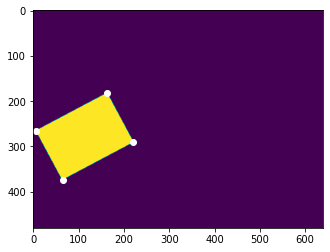

In [167]:
# Создадим оси и фигуру
fig, ax = plt.subplots()
# Покажем координаты точек прямоугольника
x, y = pred_coord.T
plt.scatter(x,y, color='w')
# Отобразим координаты на изображении с прямоугольником
ax.imshow(img)
plt.show()